In [1]:
from google.colab import files

files.upload(); # upload your kaggle.json file

Saving kaggle.json to kaggle.json


In [2]:
import json

!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [3]:
!kaggle competitions download -c isic-2024-challenge

100% 2.00G/2.00G [01:42<00:00, 19.4MB/s]
100% 2.00G/2.00G [01:42<00:00, 21.0MB/s]


In [4]:
!cd competitions/isic-2024-challenge/ && unzip -q -o *.zip


In [2]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import time
from torch.optim import AdamW
from torchvision import transforms
import timm

In [6]:
def load_and_preprocess_data(root_dir, external_train_dir):
    """
    Load and preprocess the data, including balancing the dataset and merging with external datasets.
    """
    data = pd.read_csv(f'{root_dir}/train-metadata.csv')
    selected_data = data[['isic_id', 'target']]
    data_target_1 = selected_data[selected_data['target'] == 1]

    num_samples_target_0 = 7000
    data_target_0 = selected_data[selected_data['target'] == 0].sample(n=num_samples_target_0, random_state=42)
    balanced_data = pd.concat([data_target_1, data_target_0], axis=0).reset_index(drop=True)

    file_list = os.listdir(external_train_dir)
    isic_2020_dataset = pd.DataFrame({
        'isic_id': ['ISIC2020_' + file for file in file_list],
        'target': 1
    })

    merged_dataset = pd.concat([balanced_data, isic_2020_dataset], ignore_index=True)

    train_val_data, test_data = train_test_split(
        merged_dataset, test_size=0.2, stratify=merged_dataset['target'], random_state=42
    )

    train_data, val_data = train_test_split(
        train_val_data, test_size=0.2, stratify=train_val_data['target'], random_state=42
    )

    return train_data, val_data, test_data

In [7]:
def load_and_preprocess_data(root_dir):
    """
    Load and preprocess the data, including balancing the dataset and merging with external datasets.
    """
    data = pd.read_csv(f'{root_dir}/train-metadata.csv')
    selected_data = data[['isic_id', 'target']]
    data_target_1 = selected_data[selected_data['target'] == 1]

    num_samples_target_0 = 7000
    data_target_0 = selected_data[selected_data['target'] == 0].sample(n=num_samples_target_0, random_state=42)
    balanced_data = pd.concat([data_target_1, data_target_0], axis=0).reset_index(drop=True)


    train_val_data, test_data = train_test_split(
        balanced_data, test_size=0.2, stratify=balanced_data['target'], random_state=42
    )

    train_data, val_data = train_test_split(
        train_val_data, test_size=0.2, stratify=train_val_data['target'], random_state=42
    )

    return train_data, val_data, test_data

In [8]:
def remove_hair(image):
    """
    Remove hair artifacts from an image using the DullRazor approach.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, thresh = cv2.threshold(blackhat, 12, 255, cv2.THRESH_BINARY)
    inpainted = cv2.inpaint(image, thresh, inpaintRadius=1, flags=cv2.INPAINT_TELEA)

    return inpainted

In [9]:
class CassavaDataset(torch.utils.data.Dataset):
    """
    Helper class for DataLoader
    """

    def __init__(self, df, data_path='isic-2024-challenge/train-image/image/',
                 secondary_data_path="isic-2020/data/malignant", mode="train", transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.secondary_data_path = secondary_data_path
        self.transforms = transforms
        self.mode = mode
    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        if img_name.startswith("ISIC2020_"):
            stripped_name = img_name.replace("ISIC2020_", "")
            img_path = os.path.join(self.secondary_data_path, f"{stripped_name}")
        else:
            img_path = os.path.join(self.data_path, f"{img_name}.jpg")
        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            img = self.transforms(img)

        return img, label

In [10]:
class HairRemovalTransform:
    def __call__(self, img):
        img_np = np.array(img)
        img_np = remove_hair(img_np)
        img = Image.fromarray(img_np)
        return img

In [11]:
def create_datasets(train_data, val_data, test_data, data_path, transforms_train, transforms_valid):
    """
    Create dataset objects for training, validation, and testing.
    """
    train_dataset = CassavaDataset(train_data, data_path=data_path, transforms=transforms_train)
    valid_dataset = CassavaDataset(val_data, data_path=data_path, transforms=transforms_valid)
    test_dataset = CassavaDataset(test_data, data_path=data_path, transforms=transforms_valid)
    return train_dataset, valid_dataset, test_dataset

In [12]:
def initialize_dataloaders(train_dataset, valid_dataset, test_dataset, batch_size, num_workers=8):
    """
    Creates DataLoader objects for training, validation, and testing.
    """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, valid_loader, test_loader

In [5]:
# ResNet model initialization
class ResNetBase(nn.Module):
    def __init__(self, n_classes, pretrained=False, model_path=None):
        super(ResNetBase, self).__init__()
        # Initialize the ResNet model
        self.model = timm.create_model("resnet50", pretrained=True)

        if pretrained and model_path:
            self.model.load_state_dict(torch.load(model_path))

        # Replace the classification head
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        self.model.to(device)  # Ensure model is on the correct device
        self.model.train()
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        for i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = self(data)
            loss = criterion(output, target)
            loss.backward()
            accuracy = (output.argmax(dim=1) == target).float().mean()

            epoch_loss += loss.item()
            epoch_accuracy += accuracy.item()

            optimizer.step()

        avg_loss = epoch_loss / len(train_loader)
        avg_accuracy = epoch_accuracy / len(train_loader)
        return avg_loss, avg_accuracy

    def validate_one_epoch(self, valid_loader, criterion, device):
        self.model.to(device)  # Ensure model is on the correct device
        self.model.eval()
        valid_loss = 0.0
        valid_accuracy = 0.0

        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = self(data)
                loss = criterion(output, target)
                accuracy = (output.argmax(dim=1) == target).float().mean()
                valid_loss += loss.item()
                valid_accuracy += accuracy.item()

        avg_loss = valid_loss / len(valid_loader)
        avg_accuracy = valid_accuracy / len(valid_loader)
        return avg_loss, avg_accuracy

def train_and_evaluate(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs):
    """
    Train and evaluate the model over multiple epochs.
    """
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    best_valid_acc = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 20)
        train_loss, train_acc = model.train_one_epoch(train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        print(f"Training: Loss = {train_loss:.4f}, Accuracy = {train_acc:.4f}")

        valid_loss, valid_acc = model.validate_one_epoch(valid_loader, criterion, device)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)
        print(f"Validation: Loss = {valid_loss:.4f}, Accuracy = {valid_acc:.4f}")

        if valid_acc > best_valid_acc:
            print(f"Validation accuracy improved from {best_valid_acc:.4f} to {valid_acc:.4f}. Saving model...")
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), "best_model.pth")

        epoch_time = time.time() - start_time
        print(f"Time for epoch {epoch + 1}: {epoch_time:.2f} seconds")

    return train_losses, valid_losses, train_accuracies, valid_accuracies


In [14]:
def train_and_evaluate(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs):
    """
    Train and evaluate the model over multiple epochs.
    """
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    best_valid_acc = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 20)
        train_loss, train_acc = model.train_one_epoch(train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        print(f"Training: Loss = {train_loss:.4f}, Accuracy = {train_acc:.4f}")

        valid_loss, valid_acc = model.validate_one_epoch(valid_loader, criterion, device)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)
        print(f"Validation: Loss = {valid_loss:.4f}, Accuracy = {valid_acc:.4f}")

        if valid_acc > best_valid_acc:
            print(f"Validation accuracy improved from {best_valid_acc:.4f} to {valid_acc:.4f}. Saving model...")
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), "best_model.pth")

        epoch_time = time.time() - start_time
        print(f"Time for epoch {epoch + 1}: {epoch_time:.2f} seconds")

    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [15]:
def visualize_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies, num_epochs):
    """
    Visualize training and validation metrics.
    """
    epochs = list(range(1, num_epochs + 1))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o', linestyle='-', linewidth=2, color='#9f86c0')
    plt.plot(epochs, valid_losses, label='Validation Loss', marker='s', linestyle='--', linewidth=2, color='#231942')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o', linestyle='-', linewidth=2, color='#9f86c0')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy', marker='s', linestyle='--', linewidth=2,
             color='#231942')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('train_validation_metrics.png', dpi=300, bbox_inches='tight')

In [16]:
def perform_cross_validation(train_data, labels, model_class, data_path, transforms_train, transforms_valid, num_epochs,
                             batch_size, k_folds, learning_rate):
    """
    Perform k-fold cross-validation.
    """
    splitter = StratifiedShuffleSplit(n_splits=k_folds, test_size=0.2, random_state=42)

    cv_train_losses = []
    cv_valid_losses = []
    cv_train_accuracies = []
    cv_valid_accuracies = []

    for fold, (train_idx, valid_idx) in enumerate(splitter.split(train_data, labels)):
        print(f"\n=== Fold {fold + 1}/{k_folds} ===")
        train_subset = Subset(
            CassavaDataset(train_data.iloc[train_idx].reset_index(drop=True),
                           data_path=data_path,
                           transforms=transforms_train),
            range(len(train_idx))
        )
        valid_subset = Subset(
            CassavaDataset(train_data.iloc[valid_idx].reset_index(drop=True),
                           data_path=data_path,
                           transforms=transforms_valid),
            range(len(valid_idx))
        )

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=8)
        valid_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=8)

        model = model_class(n_classes=2, pretrained=True)
        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
        criterion = nn.CrossEntropyLoss()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        fold_train_losses = []
        fold_valid_losses = []
        fold_train_accuracies = []
        fold_valid_accuracies = []

        best_valid_loss = 1.0
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")
            train_loss, train_acc = model.train_one_epoch(train_loader, criterion, optimizer, device)
            fold_train_losses.append(train_loss)
            fold_train_accuracies.append(train_acc)
            print(f"Training: Loss = {train_loss:.4f}, Accuracy = {train_acc:.4f}")

            valid_loss, valid_acc = model.validate_one_epoch(valid_loader, criterion, device)
            fold_valid_losses.append(valid_loss)
            fold_valid_accuracies.append(valid_acc)
            print(f"Validation: Loss = {valid_loss:.4f}, Accuracy = {valid_acc:.4f}")

            if valid_loss < best_valid_loss:
                print(f"Validation loss improved from {best_valid_loss:.4f} to {valid_loss:.4f}. Saving model...")
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), f"best_model_fold_{fold + 1}.pth")
        cv_train_losses.append(np.mean(fold_train_losses))
        cv_valid_losses.append(np.mean(fold_valid_losses))
        cv_train_accuracies.append(np.mean(fold_train_accuracies))
        cv_valid_accuracies.append(np.mean(fold_valid_accuracies))

    return cv_train_losses, cv_valid_losses, cv_train_accuracies, cv_valid_accuracies

In [17]:
IMG_SIZE = 224
NUM_WORKERS = 8
# Transformations applied to train images set
transforms_train = transforms.Compose(
    [
        HairRemovalTransform(),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

# Transformations applied to validation images set
transforms_valid = transforms.Compose(
    [
        HairRemovalTransform(),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

# Example Usage:
# 1. Load and preprocess data
# train_data, val_data, test_data = load_and_preprocess_data('ROOT_DIR', 'EXTERNAL_TRAIN_DIR')

# 2. Create datasets train_dataset, valid_dataset, test_dataset = CassavaDataset(train_data, val_data, train_data,
# data_path='isic-2024-challenge/train-image/image/', transforms_train, transforms_valid)

# 3. Initialize DataLoaders train_loader, valid_loader, test_loader = initialize_dataloaders(train_dataset,
# valid_dataset, test_dataset, batch_size=32, NUM_WORKERS)

# 4. Train and evaluate model model = ViTBase16(n_classes=2, pretrained=True) optimizer = AdamW(model.parameters(),
# lr=1e-4, weight_decay=0.01) criterion = nn.CrossEntropyLoss() device = torch.device("cuda" if
# torch.cuda.is_available() else "cpu") train_losses, valid_losses, train_accuracies, valid_accuracies =
# train_and_evaluate(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=20)

# 5. Visualize metrics
# visualize_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies, num_epochs=20)

# 6. Perform cross-validation cv_train_losses, cv_valid_losses, cv_train_accuracies, cv_valid_accuracies =
# perform_cross_validation(train_data, train_data['target'], ViTBase16, 'DATA_PATH', transforms_train,
# transforms_valid, num_epochs=20, batch_size=32, k_folds=5, learning_rate=1e-4)

In [6]:
model = ResNetBase(n_classes=2, pretrained=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

<ipython-input-7-32eaa94b19d6>:5: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'{root_dir}/train-metadata.csv')
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 1/20
--------------------
Training: Loss = 0.2891, Accuracy = 0.9463
Validation: Loss = 0.2088, Accuracy = 0.9468
Validation accuracy improved from 0.0000 to 0.9468. Saving model...
Time for epoch 1: 57.16 seconds

Epoch 2/20
--------------------
Training: Loss = 0.1877, Accuracy = 0.9469
Validation: Loss = 0.1946, Accuracy = 0.9468
Time for epoch 2: 56.49 seconds

Epoch 3/20
--------------------
Training: Loss = 0.1707, Accuracy = 0.9469
Validation: Loss = 0.1872, Accuracy = 0.9468
Time for epoch 3: 60.47 seconds

Epoch 4/20
--------------------
Training: Loss = 0.1654, Accuracy = 0.9470
Validation: Loss = 0.1837, Accuracy = 0.9468
Time for epoch 4: 57.87 seconds

Epoch 5/20
--------------------
Training: Loss = 0.1650, Accuracy = 0.9470
Validation: Loss = 0.1756, Accuracy = 0.9468
Time for epoch 5: 56.59 seconds

Epoch 6/20
--------------------
Training: Loss = 0.1594, Accuracy = 0.9470
Validation: Loss = 0.1742, Accuracy = 0.9468
Time for epoch 6: 61.12 seconds

Epoch 7/20
--

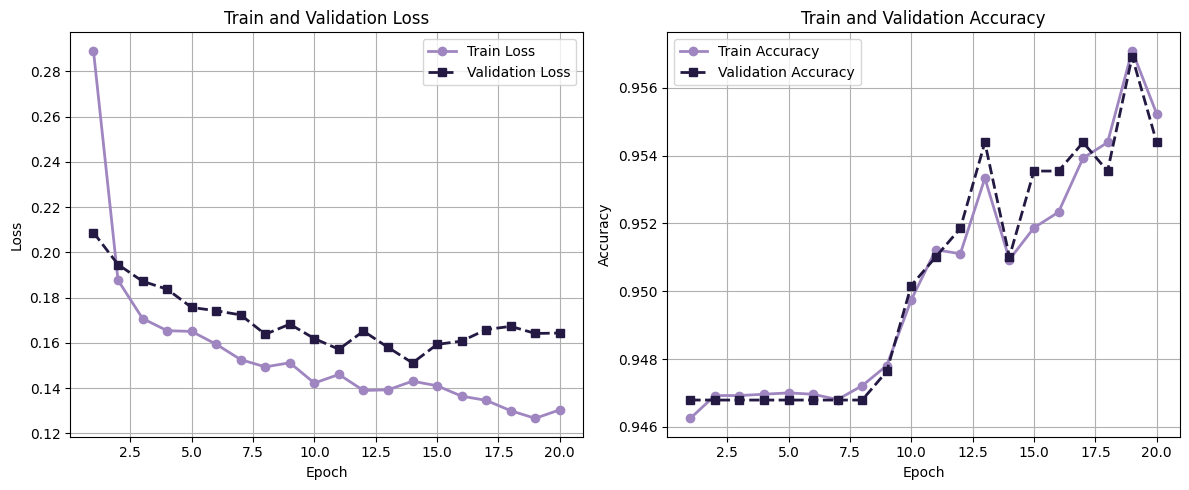

In [23]:
train_data, val_data, test_data = load_and_preprocess_data('/content/competitions/isic-2024-challenge/')
train_dataset, valid_dataset, test_dataset = create_datasets(
    train_data,
    val_data,
    test_data,
    '/content/competitions/isic-2024-challenge/train-image/image/',
    transforms_train,
    transforms_valid)
train_loader, valid_loader, test_loader = initialize_dataloaders(train_dataset, valid_dataset, test_dataset, batch_size=32, num_workers=NUM_WORKERS)
model = ResNetBase(n_classes=2, pretrained=True)
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_losses, valid_losses, train_accuracies, valid_accuracies = train_and_evaluate(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=20)
visualize_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies, num_epochs=20)

In [66]:
cv_train_losses, cv_valid_losses, cv_train_accuracies, cv_valid_accuracies = perform_cross_validation(
    train_data, train_data['target'], ResNetBase, 'train-image/image/', transforms_train,
    transforms_valid, num_epochs=20, batch_size=32, k_folds=5, learning_rate=1e-4)

device(type='cpu')

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np


In [25]:
def calculate_pauc_above_tpr(y_true, y_scores, tpr_threshold=0.8):
    """
    Calculate the partial AUC (pAUC) for TPR >= threshold.
    Args:
        y_true (array-like): True binary labels (0 or 1).
        y_scores (array-like): Predicted probabilities for the positive class.
        tpr_threshold (float): Minimum TPR threshold for pAUC calculation.
    Returns:
        pauc (float): Partial AUC value above the specified TPR threshold.
    """
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)

    # Filter TPR values above the threshold
    tpr_above = tpr[tpr >= tpr_threshold]
    fpr_above = fpr[:len(tpr_above)]  # Align FPR with the filtered TPR

    # Compute partial AUC for the region where TPR >= threshold
    pauc = auc(fpr_above, tpr_above) if len(tpr_above) > 1 else 0.0  # Handle edge case
    return pauc


In [30]:
def plot_roc_with_tpr_threshold(y_true, y_scores, tpr_threshold=0.8):
    """
    Plot ROC curve and highlight the region where TPR >= threshold.
    Args:
        y_true (array-like): True binary labels.
        y_scores (array-like): Predicted probabilities for the positive class.
        tpr_threshold (float): Minimum TPR threshold to highlight.
    """
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)

    # Highlight TPR above the threshold
    tpr_above = tpr[tpr >= tpr_threshold]
    fpr_above = fpr[:len(tpr_above)]  # Align FPR with the filtered TPR

    # Plot full ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label="ROC Curve")
    plt.fill_between(fpr_above, 0, tpr_above, color='skyblue', alpha=0.5,
                     label=f"pAUC (TPR ≥ {tpr_threshold:.2f})")

    # Add diagonal line for random chance
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Chance")

    # Add labels and legend
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"ROC Curve with Partial AUC (TPR ≥ {tpr_threshold:.2f})")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()


In [7]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()  # Set the model to evaluation mode
model.to(device)  # Move model to the correct device

<ipython-input-7-e6f270899c5f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


FileNotFoundError: [Errno 2] No such file or directory: 'best_model.pth'

In [27]:
y_true = []
y_scores = []

# Iterate over the validation loader
with torch.no_grad():
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)

        # Get model predictions
        outputs = model(data)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Probability for the positive class

        # Collect true labels and predicted probabilities
        y_true.extend(target.cpu().numpy())
        y_scores.extend(probabilities.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [28]:
pauc = calculate_pauc_above_tpr(y_true, y_scores, tpr_threshold=0.8)
print(f"Partial AUC above 80% TPR: {pauc:.4f}")



Partial AUC (pAUC) under FPR threshold 0.1: 0.0418


In [29]:
with open("pauc_results.txt", "w") as f:
    f.write(f"pAUC (FPR threshold {tpr_threshold}): {pauc:.4f}\n")


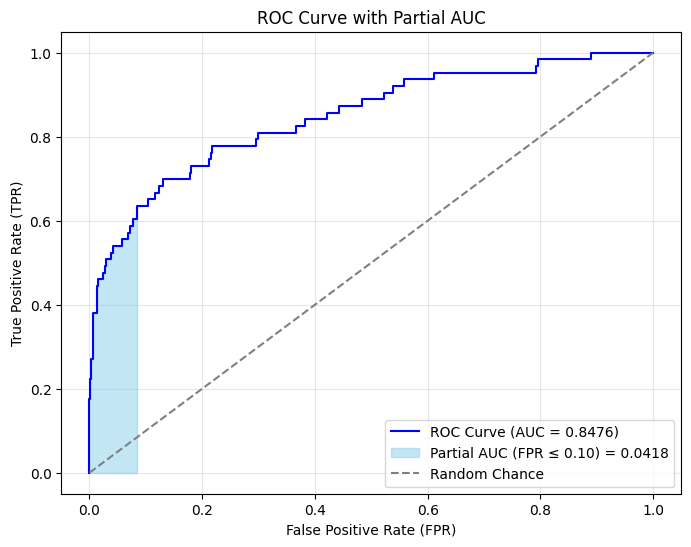

In [31]:
plot_roc_with_tpr_threshold(y_true, y_scores, tpr_threshold=0.8)


In [32]:
plt.savefig("roc_with_pauc.png", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

### Adding SIIM-ISIC dataset

In [34]:
!kaggle competitions download -c siim-isic-melanoma-classification #isic2020

 71% 74.7G/106G [1:01:53<25:43, 21.6MB/s]
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 63, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1037, in competition_download_cli
    self.competition_download_files(competition, path, force,
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1005, in competition_download_files
    self.download_file(response, outfile, quiet, not force)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1972, in download_file
    out.write(data)
OSError: [Errno 28] No space left on device


In [35]:
def load_and_preprocess_data(root_dir, external_train_dir):
    """
    Load and preprocess the data, including balancing the dataset and merging with external datasets.
    """
    data = pd.read_csv(f'{root_dir}/train-metadata.csv')
    selected_data = data[['isic_id', 'target']]
    data_target_1 = selected_data[selected_data['target'] == 1]

    num_samples_target_0 = 7000
    data_target_0 = selected_data[selected_data['target'] == 0].sample(n=num_samples_target_0, random_state=42)
    balanced_data = pd.concat([data_target_1, data_target_0], axis=0).reset_index(drop=True)

    file_list = os.listdir(external_train_dir)
    isic_2020_dataset = pd.DataFrame({
        'isic_id': ['ISIC2020_' + file for file in file_list],
        'target': 1
    })

    merged_dataset = pd.concat([balanced_data, isic_2020_dataset], ignore_index=True)

    train_val_data, test_data = train_test_split(
        merged_dataset, test_size=0.2, stratify=merged_dataset['target'], random_state=42
    )

    train_data, val_data = train_test_split(
        train_val_data, test_size=0.2, stratify=train_val_data['target'], random_state=42
    )

    return train_data, val_data, test_data

In [36]:
def remove_hair(image):
    """
    Remove hair artifacts from an image using the DullRazor approach.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, thresh = cv2.threshold(blackhat, 12, 255, cv2.THRESH_BINARY)
    inpainted = cv2.inpaint(image, thresh, inpaintRadius=1, flags=cv2.INPAINT_TELEA)

    return inpainted

In [37]:
class CassavaDataset(torch.utils.data.Dataset):
    """
    Helper class for DataLoader
    """

    def __init__(self, df, data_path='isic-2024-challenge/train-image/image/',
                 secondary_data_path="isic-2020/data/malignant", mode="train", transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.secondary_data_path = secondary_data_path
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        if img_name.startswith("ISIC2020_"):
            stripped_name = img_name.replace("ISIC2020_", "")
            img_path = os.path.join(self.secondary_data_path, f"{stripped_name}")
        else:
            img_path = os.path.join(self.data_path, f"{img_name}.jpg")
        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            img = self.transforms(img)

        return img, label

In [38]:
class HairRemovalTransform:
    def __call__(self, img):
        img_np = np.array(img)
        img_np = remove_hair(img_np)
        img = Image.fromarray(img_np)
        return img

In [39]:
def create_datasets(train_data, val_data, test_data, data_path, transforms_train, transforms_valid):
    """
    Create dataset objects for training, validation, and testing.
    """
    train_dataset = CassavaDataset(train_data, data_path=data_path, transforms=transforms_train)
    valid_dataset = CassavaDataset(val_data, data_path=data_path, transforms=transforms_valid)
    test_dataset = CassavaDataset(test_data, data_path=data_path, transforms=transforms_valid)
    return train_dataset, valid_dataset, test_dataset

In [40]:
def initialize_dataloaders(train_dataset, valid_dataset, test_dataset, batch_size, num_workers=8):
    """
    Creates DataLoader objects for training, validation, and testing.
    """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, valid_loader, test_loader


In [41]:
# ResNet model initialization
class ResNetBase(nn.Module):
    def __init__(self, n_classes, pretrained=False, model_path=None):
        super(ResNetBase, self).__init__()
        # Initialize the ResNet model
        self.model = timm.create_model("resnet50", pretrained=True)

        if pretrained and model_path:
            self.model.load_state_dict(torch.load(model_path))

        # Replace the classification head
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        self.model.to(device)  # Ensure model is on the correct device
        self.model.train()
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        for i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = self(data)
            loss = criterion(output, target)
            loss.backward()
            accuracy = (output.argmax(dim=1) == target).float().mean()

            epoch_loss += loss.item()
            epoch_accuracy += accuracy.item()

            optimizer.step()

        avg_loss = epoch_loss / len(train_loader)
        avg_accuracy = epoch_accuracy / len(train_loader)
        return avg_loss, avg_accuracy

    def validate_one_epoch(self, valid_loader, criterion, device):
        self.model.to(device)  # Ensure model is on the correct device
        self.model.eval()
        valid_loss = 0.0
        valid_accuracy = 0.0

        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = self(data)
                loss = criterion(output, target)
                accuracy = (output.argmax(dim=1) == target).float().mean()
                valid_loss += loss.item()
                valid_accuracy += accuracy.item()

        avg_loss = valid_loss / len(valid_loader)
        avg_accuracy = valid_accuracy / len(valid_loader)
        return avg_loss, avg_accuracy



In [42]:
def train_and_evaluate(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs):
    """
    Train and evaluate the model over multiple epochs.
    """
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    best_pauc = 0.0  # Initialize best pAUC for saving the model

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 20)

        # Train for one epoch
        train_loss, train_acc = model.train_one_epoch(train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        print(f"Training: Loss = {train_loss:.4f}, Accuracy = {train_acc:.4f}")

        # Validate for one epoch (with pAUC calculation)
        valid_loss, pauc = validate_one_epoch_with_pauc(valid_loader, model, criterion, device, fpr_threshold=0.8)
        valid_losses.append(valid_loss)
        valid_accuracies.append(pauc)
        print(f"Validation: Loss = {valid_loss:.4f}, pAUC = {pauc:.4f}")

        # Save the model if pAUC improves
        if pauc > best_pauc:
            print(f"pAUC improved from {best_pauc:.4f} to {pauc:.4f}. Saving model...")
            best_pauc = pauc
            torch.save(model.state_dict(), "best_model.pth")

    return train_losses, valid_losses, train_accuracies, valid_accuracies


In [43]:
def visualize_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies, num_epochs, y_true=None, y_scores=None, fpr_threshold=0.8):
    """
    Visualize training and validation metrics, and plot partial AUC (pAUC).
    Args:
        train_losses (list): Training loss for each epoch.
        valid_losses (list): Validation loss for each epoch.
        train_accuracies (list): Training accuracy for each epoch.
        valid_accuracies (list): Validation accuracy (or pAUC) for each epoch.
        num_epochs (int): Number of epochs.
        y_true (array-like, optional): True binary labels for pAUC calculation.
        y_scores (array-like, optional): Predicted probabilities for pAUC calculation.
        fpr_threshold (float, optional): Maximum FPR for the pAUC region (default: 0.8).
    """
    epochs = list(range(1, num_epochs + 1))

    # Plot Loss and Accuracy Metrics
    plt.figure(figsize=(16, 6))

    # Loss Plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o', linestyle='-', linewidth=2, color='#9f86c0')
    plt.plot(epochs, valid_losses, label='Validation Loss', marker='s', linestyle='--', linewidth=2, color='#231942')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o', linestyle='-', linewidth=2, color='#9f86c0')
    plt.plot(epochs, valid_accuracies, label='Validation pAUC', marker='s', linestyle='--', linewidth=2, color='#231942')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy / pAUC')
    plt.title('Train Accuracy and Validation pAUC')
    plt.legend()
    plt.grid(True)

    # pAUC Plot (Partial ROC Curve)
    if y_true is not None and y_scores is not None:
        # Compute ROC and pAUC
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        fpr_partial = fpr[fpr <= fpr_threshold]
        tpr_partial = tpr[:len(fpr_partial)]
        pauc = auc(fpr_partial, tpr_partial)

        plt.subplot(1, 3, 3)
        plt.plot(fpr, tpr, label="ROC Curve", color='blue')
        plt.fill_between(fpr_partial, 0, tpr_partial, color='skyblue', alpha=0.5,
                         label=f"pAUC (FPR ≤ {fpr_threshold:.2f}) = {pauc:.4f}")
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Chance")
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.title(f"Partial ROC Curve (pAUC)")
        plt.legend(loc="lower right")
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('metrics_and_pauc.png', dpi=300, bbox_inches='tight')
    print("Metrics and pAUC plot saved as 'metrics_and_pauc.png'")
    plt.show()


In [44]:
def perform_cross_validation(train_data, labels, model_class, data_path, transforms_train, transforms_valid, num_epochs,
                             batch_size, k_folds, learning_rate, fpr_threshold=0.8):
    """
    Perform k-fold cross-validation with pAUC evaluation.
    Args:
        train_data: DataFrame containing training data information.
        labels: Labels for the training data.
        model_class: The class of the model to be used.
        data_path: Path to the dataset.
        transforms_train: Transformations to apply to the training data.
        transforms_valid: Transformations to apply to the validation data.
        num_epochs: Number of epochs to train.
        batch_size: Batch size for training.
        k_folds: Number of folds for cross-validation.
        learning_rate: Learning rate for the optimizer.
        fpr_threshold: Maximum FPR for pAUC calculation.
    """

    splitter = StratifiedShuffleSplit(n_splits=k_folds, test_size=0.2, random_state=42)

    cv_train_losses = []
    cv_valid_losses = []
    cv_train_accuracies = []
    cv_valid_paucs = []  # Store pAUC for each fold

    for fold, (train_idx, valid_idx) in enumerate(splitter.split(train_data, labels)):
        print(f"\n=== Fold {fold + 1}/{k_folds} ===")
        train_subset = Subset(
            CassavaDataset(train_data.iloc[train_idx].reset_index(drop=True),
                           data_path=data_path,
                           transforms=transforms_train),
            range(len(train_idx))
        )
        valid_subset = Subset(
            CassavaDataset(train_data.iloc[valid_idx].reset_index(drop=True),
                           data_path=data_path,
                           transforms=transforms_valid),
            range(len(valid_idx))
        )

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=8)
        valid_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=8)

        model = model_class(n_classes=2, pretrained=True)
        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
        criterion = nn.CrossEntropyLoss()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        fold_train_losses = []
        fold_valid_losses = []
        fold_train_accuracies = []
        fold_valid_paucs = []  # Store pAUC for each epoch

        best_pauc = 0.0  # Initialize the best pAUC for saving the model
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")
            train_loss, train_acc = model.train_one_epoch(train_loader, criterion, optimizer, device)
            fold_train_losses.append(train_loss)
            fold_train_accuracies.append(train_acc)
            print(f"Training: Loss = {train_loss:.4f}, Accuracy = {train_acc:.4f}")

            # Validation with pAUC
            valid_loss, y_true, y_scores = 0.0, [], []
            model.eval()
            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)
                    valid_loss += loss.item()

                    # Collect true labels and predicted probabilities
                    y_true.extend(target.cpu().numpy())
                    y_scores.extend(torch.softmax(output, dim=1)[:, 1].cpu().numpy())

            valid_loss /= len(valid_loader)

            # Calculate pAUC
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            fpr_partial = fpr[fpr <= fpr_threshold]
            tpr_partial = tpr[:len(fpr_partial)]
            pauc = auc(fpr_partial, tpr_partial) if len(tpr_partial) > 1 else 0.0

            fold_valid_losses.append(valid_loss)
            fold_valid_paucs.append(pauc)
            print(f"Validation: Loss = {valid_loss:.4f}, pAUC = {pauc:.4f}")

            # Save the model if pAUC improves
            if pauc > best_pauc:
                print(f"pAUC improved from {best_pauc:.4f} to {pauc:.4f}. Saving model...")
                best_pauc = pauc
                torch.save(model.state_dict(), f"best_model_fold_{fold + 1}.pth")

        # Append metrics for this fold
        cv_train_losses.append(np.mean(fold_train_losses))
        cv_valid_losses.append(np.mean(fold_valid_losses))
        cv_train_accuracies.append(np.mean(fold_train_accuracies))
        cv_valid_paucs.append(np.mean(fold_valid_paucs))

    return cv_train_losses, cv_valid_losses, cv_train_accuracies, cv_valid_paucs


In [45]:
IMG_SIZE = 224
NUM_WORKERS = 8
# Transformations applied to train images set
transforms_train = transforms.Compose(
    [
        HairRemovalTransform(),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

# Transformations applied to validation images set
transforms_valid = transforms.Compose(
    [
        HairRemovalTransform(),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

# Example Usage:
# 1. Load and preprocess data
# train_data, val_data, test_data = load_and_preprocess_data('ROOT_DIR', 'EXTERNAL_TRAIN_DIR')

# 2. Create datasets train_dataset, valid_dataset, test_dataset = CassavaDataset(train_data, val_data, train_data,
# data_path='isic-2024-challenge/train-image/image/', transforms_train, transforms_valid)

# 3. Initialize DataLoaders train_loader, valid_loader, test_loader = initialize_dataloaders(train_dataset,
# valid_dataset, test_dataset, batch_size=32, NUM_WORKERS)

# 4. Train and evaluate model model = ViTBase16(n_classes=2, pretrained=True) optimizer = AdamW(model.parameters(),
# lr=1e-4, weight_decay=0.01) criterion = nn.CrossEntropyLoss() device = torch.device("cuda" if
# torch.cuda.is_available() else "cpu") train_losses, valid_losses, train_accuracies, valid_accuracies =
# train_and_evaluate(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=20)

# 5. Visualize metrics
# visualize_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies, num_epochs=20)

# 6. Perform cross-validation cv_train_losses, cv_valid_losses, cv_train_accuracies, cv_valid_accuracies =
# perform_cross_validation(train_data, train_data['target'], ViTBase16, 'DATA_PATH', transforms_train,
# transforms_valid, num_epochs=20, batch_size=32, k_folds=5, learning_rate=1e-4)

In [ ]:
train_data, val_data, test_data = load_and_preprocess_data('/content/competitions/isic-2024-challenge/', '/content/competitions/siim-isic-melanoma-classification')
train_dataset, valid_dataset, test_dataset = create_datasets(
    train_data,
    val_data,
    test_data,
    '/content/competitions/isic-2024-challenge/train-image/image/',
    transforms_train,
    transforms_valid)
train_loader, valid_loader, test_loader = initialize_dataloaders(train_dataset, valid_dataset, test_dataset, batch_size=32, num_workers=NUM_WORKERS)
model = ResNetBase(n_classes=2, pretrained=True)
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_losses, valid_losses, train_accuracies, valid_accuracies = train_and_evaluate(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=20)
visualize_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies, num_epochs=20)

<ipython-input-35-7ca2fdd6c54e>:5: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'{root_dir}/train-metadata.csv')
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 1/20
--------------------


Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 244, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 244, in _feed
    obj = _ForkingPickler.dumps(obj)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/usr/lib/python3.10/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 244, in _feed
    obj = _ForkingPickler.dumps(obj)
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 244, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/usr/local/lib/python3.10/dist-packages/torch/multiprocessing/reductions.py", line 619, in reduce_storage
    df = multiprocessing.reduction.DupFd(fd